### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [21]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

### Read the test and train dataset from the checkpoint

In [2]:
train_df = pd.read_csv("../data/train_dataset_w59types.csv")

In [3]:
train_df.shape

(7234, 11)

## Data Preprocessing

In [4]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_id                                7234
project_name                              7168
methodologyorprotocol                      292
fully_harmonized_methodologyorprotocol     277
region                                       8
voluntary_registry                           4
type_from_registry                          99
project_developer                         2512
arborwa_project                              3
type                                        59
rule-based_type_mapping_first               50
dtype: int64


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [5]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1147
1,Wind,811
2,Improved Forest Management,605
3,Hydropower,423
4,Afforestation/Reforestation,378
5,Manure Methane Digester,359
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,258
9,Rice Emission Reductions,234


In [295]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [6]:
X_train_df = train_df.drop(columns=['type'])
Y_train_df = train_df['type']

In [7]:
print(X_train_df.shape)

(7234, 10)


In [8]:
## Splitting the train to train and validation sets
X_train_1, X_val_1, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train_1.shape, X_val_1.shape, Y_train.shape, Y_val.shape )

(6510, 10) (724, 10) (6510,) (724,)


In [10]:
X_train = X_train_1.drop(columns=['project_id','rule-based_type_mapping_first', 'methodologyorprotocol'])
X_val = X_val_1.drop(columns=['project_id','rule-based_type_mapping_first', 'methodologyorprotocol'])


## Encoding the categorical and text features


In [11]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwa_project']
text_features = ['project_name','fully_harmonized_methodologyorprotocol','type_from_registry', 'project_developer']

In [12]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = RandomOverSampler(random_state=42)
sampling_strategy = {
    'Cookstoves': 800
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [13]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(47200, 11646) (47200,)
float64


In [14]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

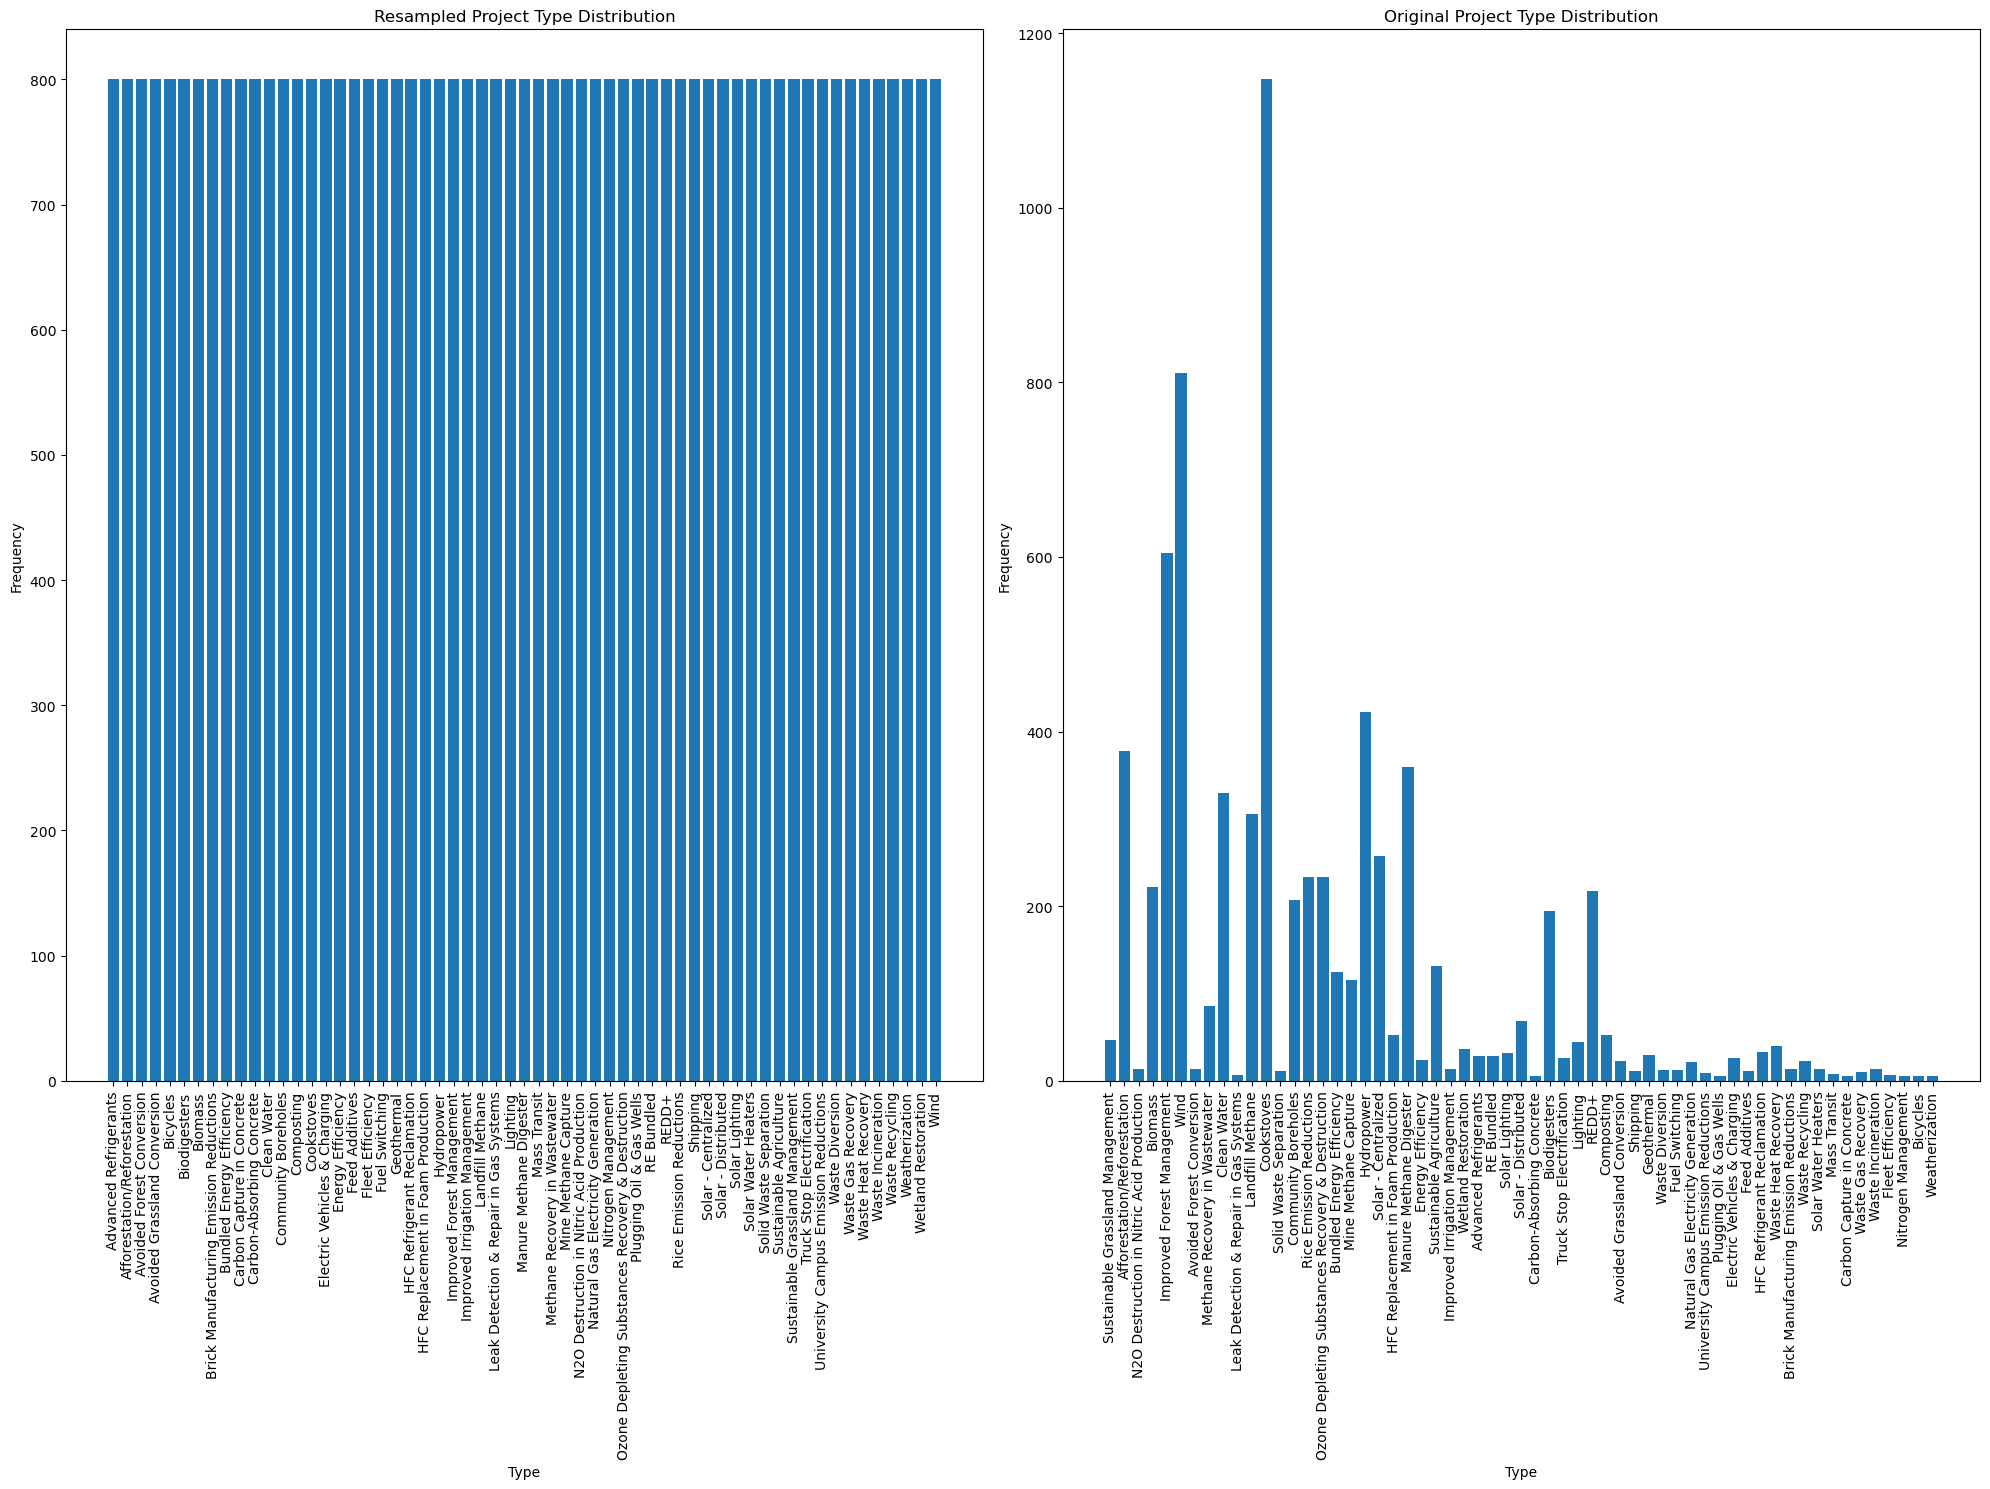

In [15]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [26]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)



LogisticRegression(max_iter=1000, random_state=42)

In [25]:
## Save the model and processor with Joblib

joblib.dump(preprocessor, '../data/models/tfidf_onehotencoding.pkl')

# Save the Logistic Regression model
joblib.dump(logistic_regression, '../data/models/logistic_regression_model.pkl')

['../data/models/logistic_regression_model.pkl']

In [27]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Get the predicted probabilities for each class
y_pred_proba = logistic_regression.predict_proba(X_val_transformed)
# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,0.925000,0.973684,0.948718,38.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
Biodigesters,1.000000,0.947368,0.972973,19.000000
Biomass,1.000000,0.909091,0.952381,22.000000
Brick Manufacturing Emission Reductions,1.000000,1.000000,1.000000,1.000000
Bundled Energy Efficiency,0.785714,0.846154,0.814815,13.000000
Carbon-Absorbing Concrete,1.000000,1.000000,1.000000,1.000000


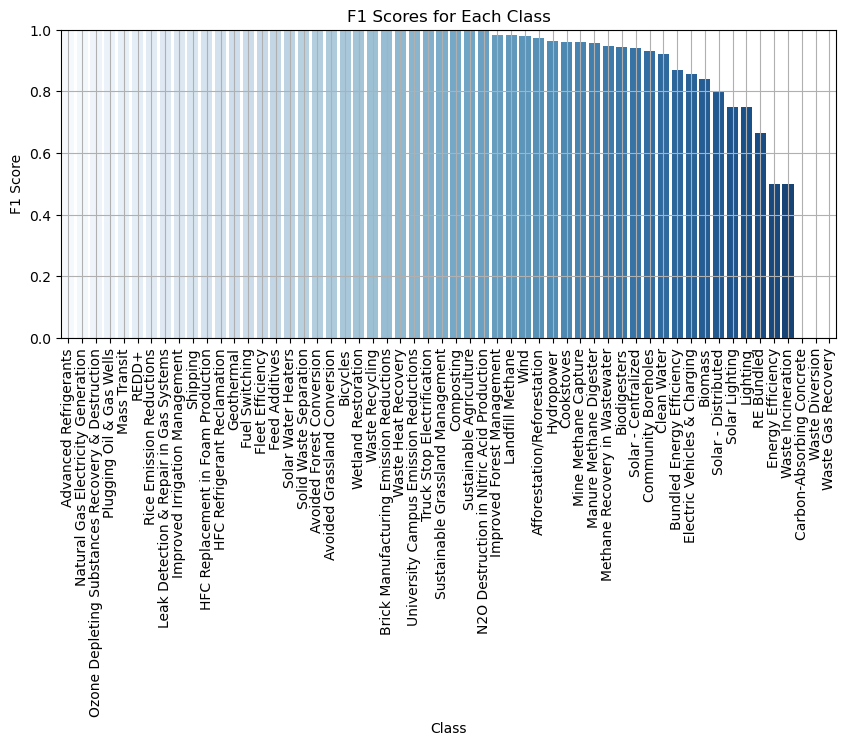

In [82]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Project Types')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [26]:
## Check all the incorrect predictions

In [19]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})

# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype
# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(47, 13)


,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
11,basilicata bamboo,AR-AMS0007 Afforestation and reforestation pro...,Europe,VCS,Agriculture Forestry and Other Land Use,Societa' Agricola Bambu’ SRL,No,Sustainable Agriculture,Afforestation/Reforestation,0.959051,False,VCS4527,Afforestation/Reforestation
39,Distributed Emission Reductions by Bboxx Energ...,AMS-III.AR. Substituting fossil fuel based lig...,,GOLD,Energy Efficiency - Domestic,BBOXX LTD,No,Bundled Energy Efficiency,Cookstoves,0.295617,False,GS11598,Solar Lighting
59,Aydin Salavatli Dora-1 Geothermal Power Plant,AMS-I.D. Grid connected renewable electricity ...,Middle East,VCS,Energy industries (renewable/non-renewable sou...,Menderes Geothermal Elektrik Uretim A.S,No,Geothermal,Hydropower,0.491857,False,VCS120,Geothermal
89,IBB Biomethanation Plant Project,ACM0022 Alternative waste treatment processes,,GOLD,Biogas - Cogeneration,ISTAÃ‡ A.S.,No,Landfill Methane,Manure Methane Digester,0.267508,False,GS7528,
98,Water and Energy for Sustainable Development P...,,,GOLD,Energy Efficiency - Domestic,United Purpose Ltd,No,Bundled Energy Efficiency,Cookstoves,0.364119,False,GS5382,
111,The Haidar EL ALI Mangrove Initiative (HEAMI),AR-AMS0003 Afforestation and reforestation pro...,Africa,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,Wetland Restoration,Afforestation/Reforestation,0.917113,False,VCS1760,Wetland Restoration
115,Bundled Solar VCS Project by EKIESL (EKIESL- V...,AMS-I.D. Grid connected renewable electricity ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Solar - Distributed,RE Bundled,0.364201,False,VCS1574,
146,Poultry litter to compost using Black Soldier ...,ACM0010 GHG emission reductions from manure ma...,Asia,VCS,Waste handling and disposal,Holocene Ecosolutions Private Limited,No,Composting,Manure Methane Digester,0.905130,False,VCS3665,
155,Energy Efficiency at Artisanal Brick Producers...,AMS-II.G. Energy efficiency measures in therma...,,GOLD,Energy Efficiency - Industrial,myclimate Foundation,No,Energy Efficiency,Cookstoves,0.574424,False,GS1384,
164,GS1247 VPA 207 Sierra Leone Safe Water,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Clean Water,Community Boreholes,0.647745,False,GS7479,


In [29]:
## Confidence level of the result

In [29]:
# Create a DataFrame to compare true labels and predictions with confidence levels
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})
# Extract the dropped feature from the original X_test

dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype

correct_predictions = comparison_df[comparison_df['Correct Prediction']]
correct_predictions

,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
0,Installation of high efficiency wood burning c...,VMR0006 Energy Efficiency and Fuel Switch Meas...,Africa,VCS,Energy demand,C-Quest Capital CR Stoves Pte. Ltd.,No,Cookstoves,Cookstoves,0.978721,True,VCS4159,
1,Wastewater Treatment with Biogas Technology in...,AMS-I.D. Grid connected renewable electricity ...,,VCS,Waste handling and disposal,Roi Et Flour Company Limited,No,Methane Recovery in Wastewater,Methane Recovery in Wastewater,0.979615,True,VCS401,
2,Liaoning Kangping IFM (conversion of logged to...,VM0010 Methodology for Improved Forest Managem...,Asia,VCS,Agriculture Forestry and Other Land Use,Kangping County Liaobei Seedling Development C...,No,Improved Forest Management,Improved Forest Management,0.977733,True,VCS2698,Improved Forest Management
3,Wuwei Liangzhou Municipal Solid Waste Incinera...,ACM0022 Alternative waste treatment processes,Asia,VCS,Energy industries (renewable/non-renewable sou...,"Wuwei everbright Environmental Energy Co., Ltd.",No,Waste Incineration,Waste Incineration,0.968483,True,VCS4169,
4,Reforestation grouped project Norteak Nicaragua,AR-ACM0003 Afforestation and reforestation of ...,Latin America,VCS,Agriculture Forestry and Other Land Use,Norteak Nicaragua S.A.,No,Afforestation/Reforestation,Afforestation/Reforestation,0.997630,True,VCS2647,Afforestation/Reforestation
...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,Developing voluntary carbon market project for...,VM0036 Methodology for Rewetting Drained Tempe...,Asia,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,REDD+,REDD+,0.897449,True,VCS3114,
720,300 MW Solar PV Plant at Bhadla Rajasthan,ACM0002 Grid-connected electricity generation ...,,GOLD,Solar Thermal - Electricity,Vijay Anand,No,Solar - Centralized,Solar - Centralized,0.995595,True,GS7726,Solar - Centralized
721,GS1247 VPA 127 Southern Ethiopia Community Bor...,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Community Boreholes,Community Boreholes,0.915277,True,GS6037,
722,Hudson Tech 2019-1,ARB Compliance Offset Protocol: Destruction of...,,ACR,Ozone Depleting Substances,Hudson Technologies Company,Compliance,Ozone Depleting Substances Recovery & Destruction,Ozone Depleting Substances Recovery & Destruction,0.998385,True,ACR445,Ozone Depleting Substances Recovery & Destruction


In [30]:
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df = comparison_df[
    (comparison_df['rule-based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule-based_type_mapping_first'] == comparison_df['True Label'].astype(str)) #&
]
rulebased_df

,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
2,Liaoning Kangping IFM (conversion of logged to...,VM0010 Methodology for Improved Forest Managem...,Asia,VCS,Agriculture Forestry and Other Land Use,Kangping County Liaobei Seedling Development C...,No,Improved Forest Management,Improved Forest Management,0.977733,True,VCS2698,Improved Forest Management
4,Reforestation grouped project Norteak Nicaragua,AR-ACM0003 Afforestation and reforestation of ...,Latin America,VCS,Agriculture Forestry and Other Land Use,Norteak Nicaragua S.A.,No,Afforestation/Reforestation,Afforestation/Reforestation,0.997630,True,VCS2647,Afforestation/Reforestation
5,Biomass Power Generation Project by Everbright...,ACM0018 Electricity generation from biomass in...,,GOLD,"Biomass, or Liquid Biofuel - Electricity",China Everbright International Limited,No,Biomass,Biomass,0.992899,True,GS2420,Biomass
6,Solar Drip Irrigation for Smallholder Farmers ...,AMS-I.A. Electricity generation by the user,,GOLD,Solar Thermal - Electricity,atmosfair gGmbH,No,Solar - Distributed,Solar - Distributed,0.782846,True,GS10823,Solar - Distributed
8,"Carbono, Agua y Biodiversidad Indígena La Trin...",CAR Mexico Forest Protocol,,CAR,Forestry - MX,INTEGRADORA DE COMUNIDADES INDIGENAS Y CAMPESI...,No,Improved Forest Management,Improved Forest Management,0.978042,True,CAR1399,Improved Forest Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,Monte Rosa Bagasse Cogeneration - CER Conversion,ACM0002 Grid-connected electricity generation ...,Latin America,VCS,Energy industries (renewable/non-renewable sou...,Credits transferred from approved GHG program,No,Biomass,Biomass,0.632057,True,VCS1507,Biomass
713,Shibeishan Wind Power Generation Project in Hu...,ACM0002 Grid-connected electricity generation ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,Guangdong Yudean Shibeishan Wind Power Develop...,No,Wind,Wind,0.957862,True,VCS725,Wind
718,Developing climate resilience of the coastal c...,AR-AM0014 Afforestation and reforestation of d...,Asia,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,Wetland Restoration,Wetland Restoration,0.953386,True,VCS3360,Wetland Restoration
720,300 MW Solar PV Plant at Bhadla Rajasthan,ACM0002 Grid-connected electricity generation ...,,GOLD,Solar Thermal - Electricity,Vijay Anand,No,Solar - Centralized,Solar - Centralized,0.995595,True,GS7726,Solar - Centralized


In [88]:
#Incorrect rule based predictions
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df_false = comparison_df[
    (comparison_df['rule_based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule_based_type_mapping_first'] != comparison_df['True Label'].astype(str)) #&
   # (comparison_df['rule_based_type_mapping_first'] == comparison_df['True Label'].astype(str))
]
print(rulebased_df_false.shape)
rulebased_df_false

(22, 13)


,project_name,fully_harmonized_methodology_protocol,version_string,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,True Label,Predicted Label,Confidence Level,Correct Prediction,rule_based_type_mapping_first
17,Biomass Briquette Based Earth Stove Project,Other,,Southern Asia,GOLD,"Biomass, or Liquid Biofuel - Heat",ClimateCare Limited,No,Cookstoves,Biomass,0.908408,False,Biomass
78,Reforestation Program in the Southeastern Regi...,GS Methodology for Afforestation/Reforestation...,,Latin America and the Caribbean,GOLD,A/R,Across Forest,No,Afforestation/Reforestation,Afforestation/Reforestation,0.974330,True,Solar Water Heaters
128,Pubu Hydropower Station Project,ACM0002 Grid-connected electricity generation ...,,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,Panzhihua Reshuihe Electric Power Development Co.,No,Hydropower,Hydropower,0.990518,True,Hydropower;Hydropower
136,Badamsha 2 Wind Farm in Kazakhstan,ACM0002 Grid-connected electricity generation ...,,Central Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Wind,Wind,0.957267,True,Hydropower
357,ECO2 Renewable Biomass Fuel Enterprise,AMS-I.E. Switch from non-renewable biomass for...,,Sub-Saharan Africa,GOLD,"Biomass, or Liquid Biofuel - Heat",myclimate Foundation,No,Cookstoves,Biomass,0.720062,False,Biomass
371,50 MW Solar PV Project by Sembcorp Green Infra...,ACM0002 Grid-connected electricity generation ...,,Southern Asia,GOLD,Solar Thermal - Electricity,Sembcorp Green Infra Limited,No,Solar - Centralized,Solar - Centralized,0.980345,True,Solar - Distributed
405,The Electric Vehicle Accelerator Programme (EVA),AMS-III.C. Emission reductions by electric and...,,South-Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,CRX CARBONBANK PTE. LTD.,No,Lighting,Electric Vehicles & Charging,0.896885,False,Electric Vehicles & Charging
430,Project Gaia Cook Stove Programme of Activitie...,AMS-I.E. Switch from non-renewable biomass for...,,Sub-Saharan Africa,GOLD,"Biomass, or Liquid Biofuel - Heat",Project Gaia,No,Cookstoves,Cookstoves,0.602344,True,Biomass
450,Small scale community-based afforestation prog...,GS Methodology for Afforestation/Reforestation...,,Sub-Saharan Africa,GOLD,A/R,Deactivated Projects,No,Afforestation/Reforestation,Afforestation/Reforestation,0.922196,True,Solar Water Heaters
451,COMACO Landscape Management Project,VM0015 Methodology for Avoided Unplanned Defor...,,Sub-Saharan Africa,VCS,Agriculture Forestry and Other Land Use,Community Markets for Conservation (COMACO),No,REDD+,REDD+,0.753276,True,Sustainable Agriculture
